# Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.analysis import plot_forecast
from etna.transforms import LagTransform
from etna.models import CatBoostMultiSegmentModel
import matplotlib.pyplot as plt

# Загрузка данных и первичный анализ

In [2]:
df = pd.read_csv('data/prices_hist.csv')
df.head()

,datetime,price
0,2018-01-05,36550.0
1,2018-01-12,36850.0
2,2018-01-19,36850.0
3,2018-01-26,35200.0
4,2018-02-02,34650.0


In [3]:
df["timestamp"] = pd.to_datetime(df["datetime"])
df["target"] = df["price"]
df.drop(columns=["datetime", "price"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,2018-01-05,36550.0,main
1,2018-01-12,36850.0,main
2,2018-01-19,36850.0,main
3,2018-01-26,35200.0,main
4,2018-02-02,34650.0,main


In [4]:
df = TSDataset.to_dataset(df)
df.head()

segment,main
feature,target
timestamp,
2018-01-05,36550.0
2018-01-12,36850.0
2018-01-19,36850.0
2018-01-26,35200.0
2018-02-02,34650.0


In [5]:
ts = TSDataset(df, freq="W-FRI")
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2018-01-05,2022-12-30,261,0,1,0,0,0,W-FRI


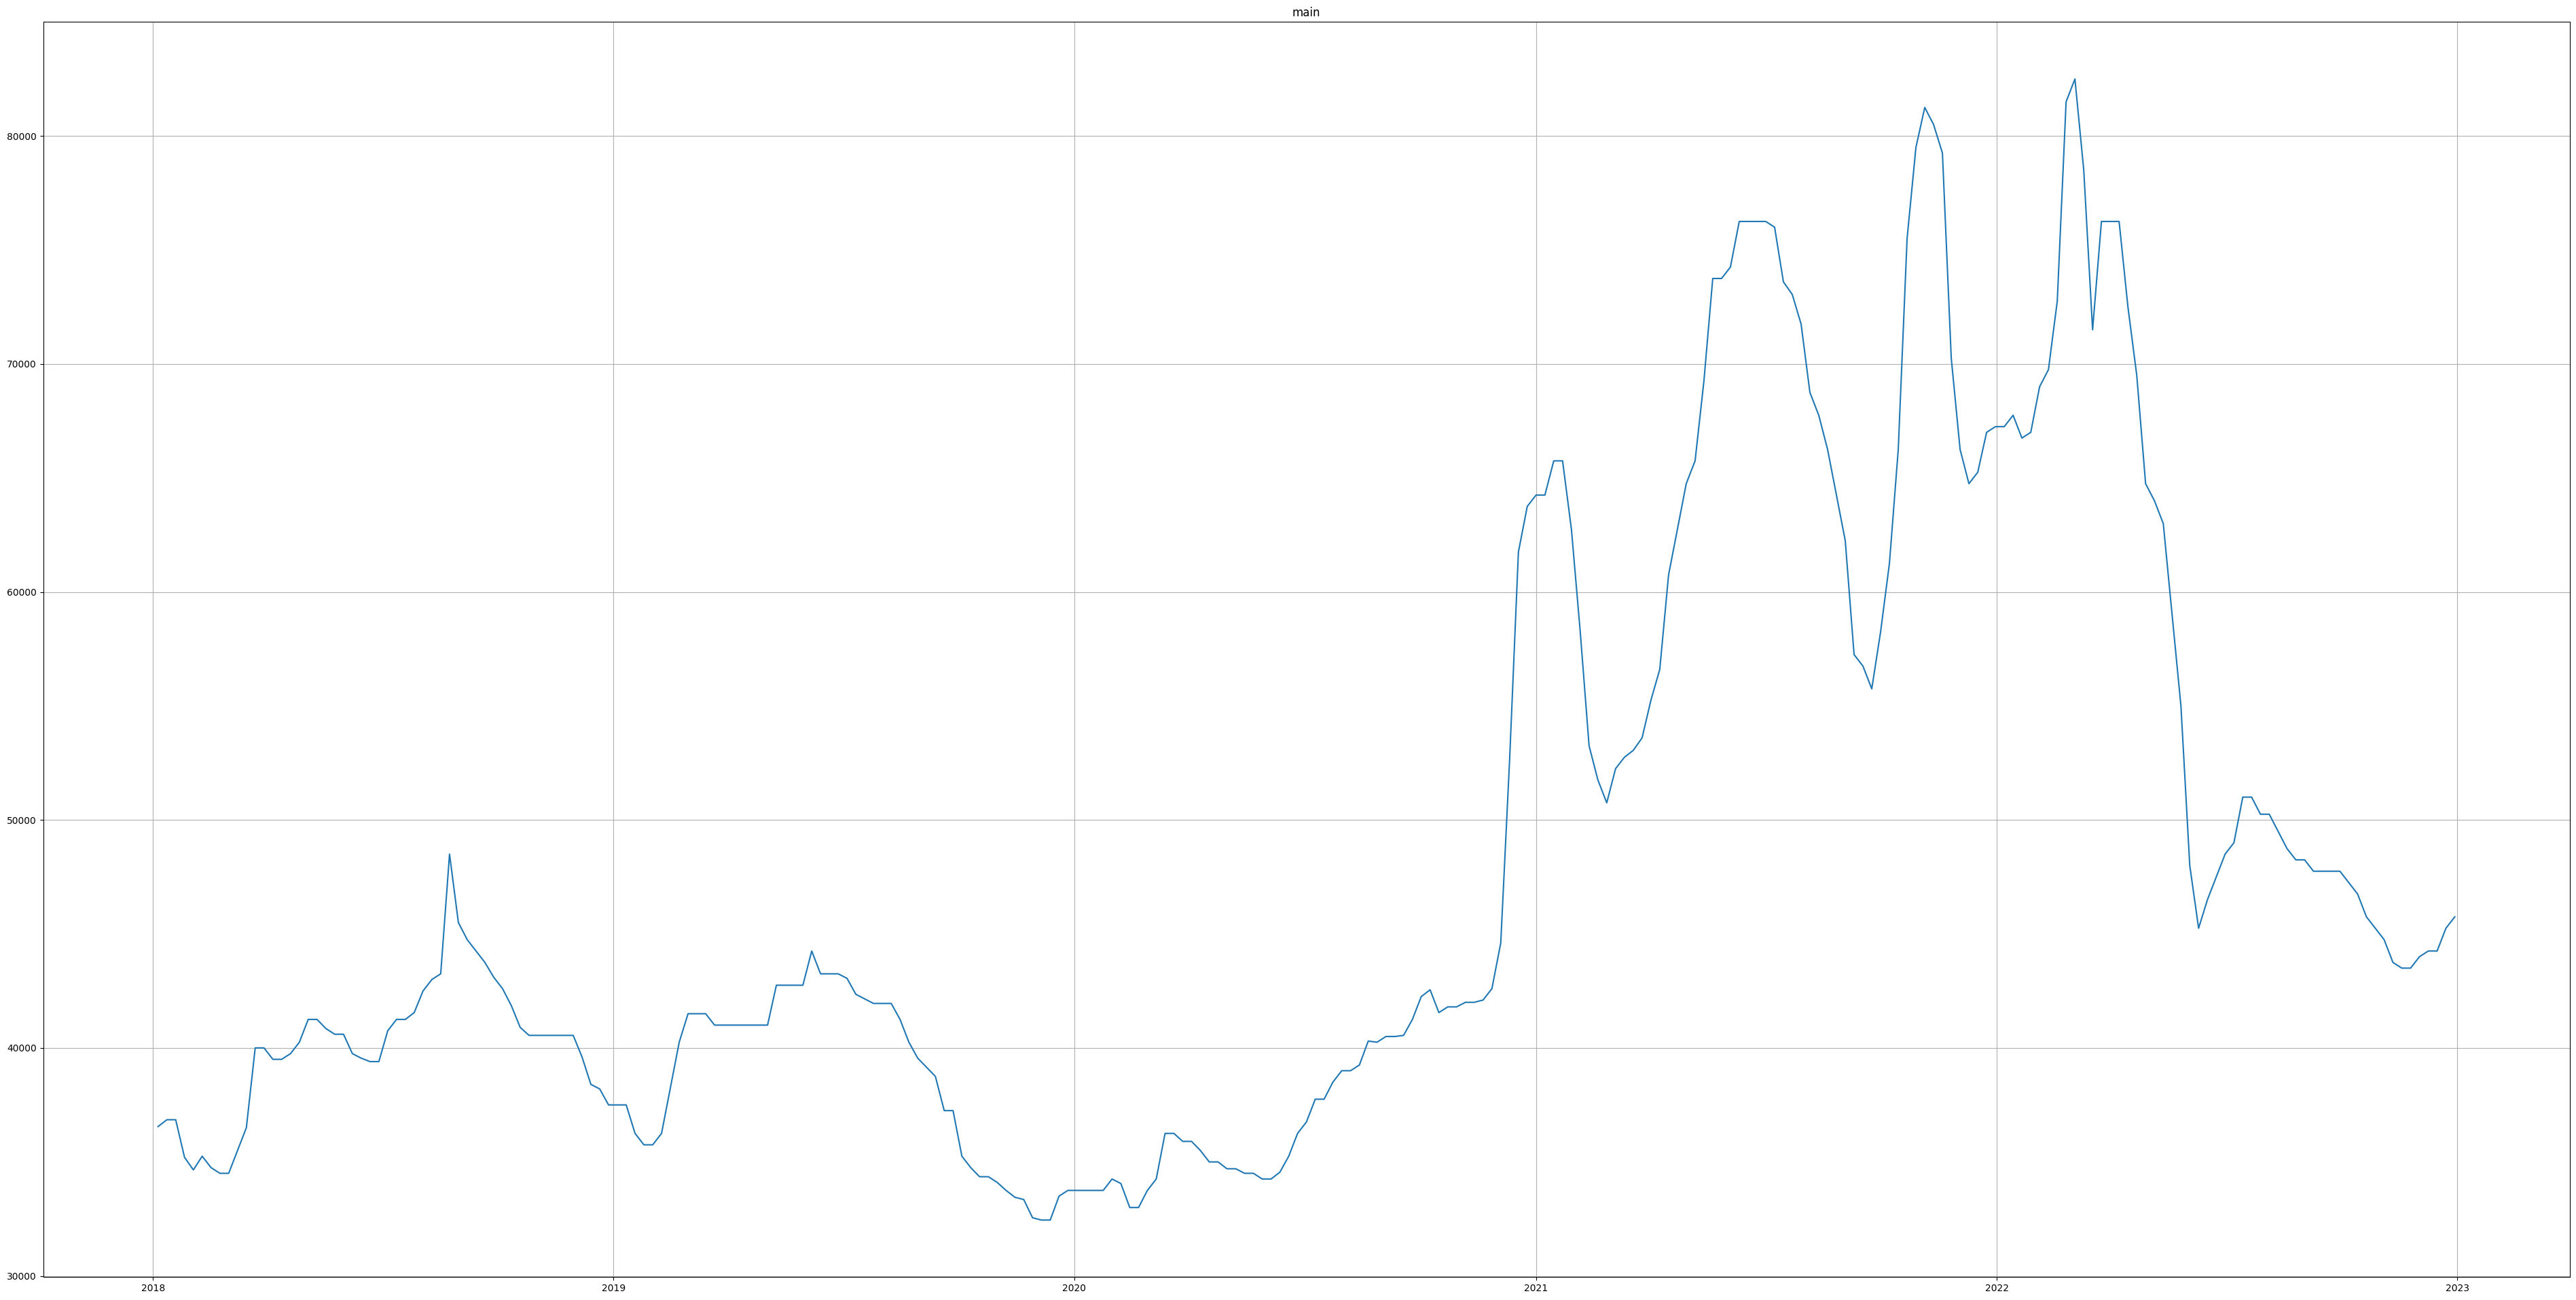

In [6]:
ts.plot(figsize=(48, 24))

# Catboost (Обучение модели и прогназирование)

Наш прогноз на данных

1.2941786310934076
1.289144306836197


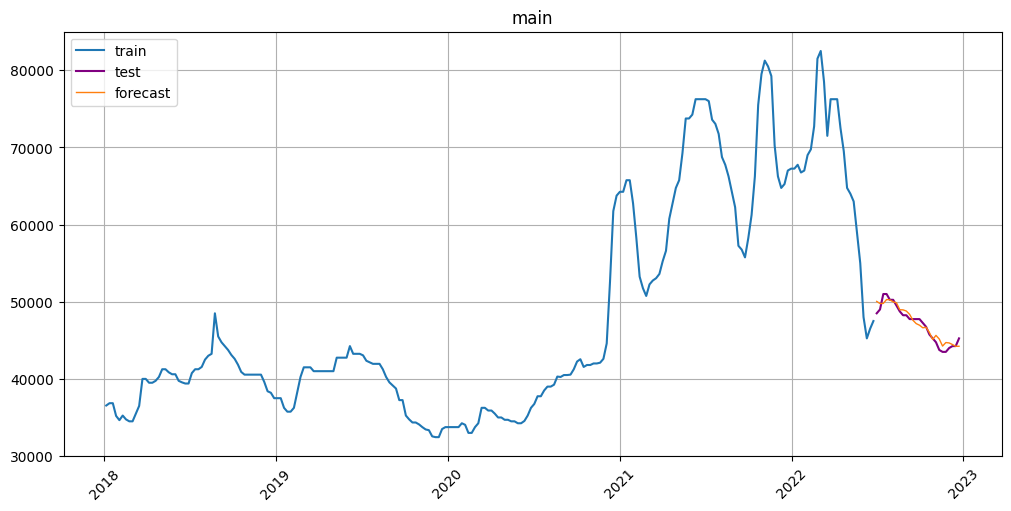

In [7]:
HORIZON = 26
mape = MAPE()
smape = SMAPE()
train_ts, test_ts = ts.train_test_split(
    train_start="2018-01-05",
    train_end="2022-06-30",
    test_start="2022-07-01",
    test_end="2022-12-23",
)
lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
train_ts.fit_transform([lags])
model = CatBoostMultiSegmentModel(iterations=1004, depth=6, learning_rate=0.0300007, l2_leaf_reg=2.001, bootstrap_type='MVS')
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=261)
print(mape(y_true=test_ts, y_pred=forecast_ts)['main'])
print(smape(y_true=test_ts, y_pred=forecast_ts)['main'])

# CUDA

Проверка доступны ли ядра cuda для вычислений на них

In [8]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
		
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")

Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 2070 Super
How many devices 1


# Обработка предсказаний

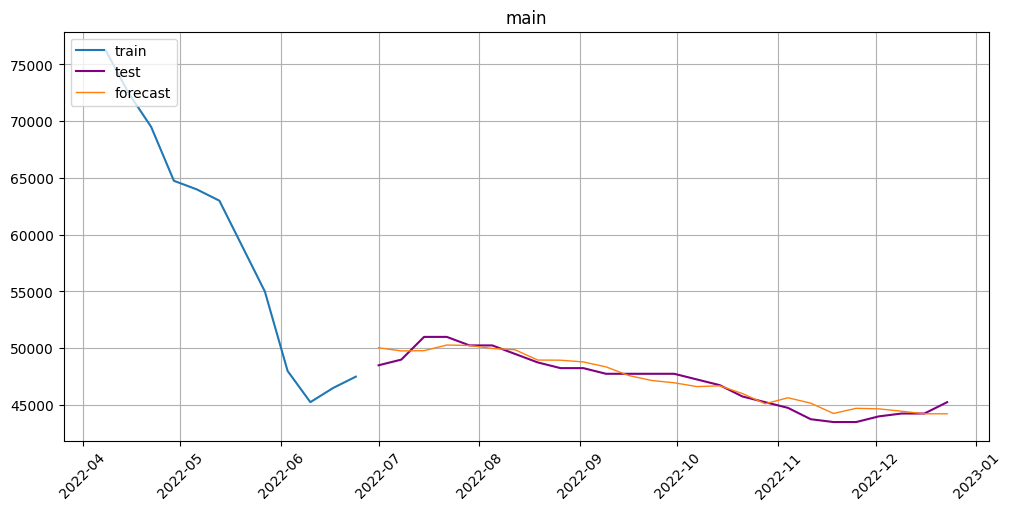

In [9]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=12)

In [10]:
test_df = test_ts.to_pandas(True)[['timestamp','target']]
forecast_df = forecast_ts.to_pandas(True)[['timestamp','target']]

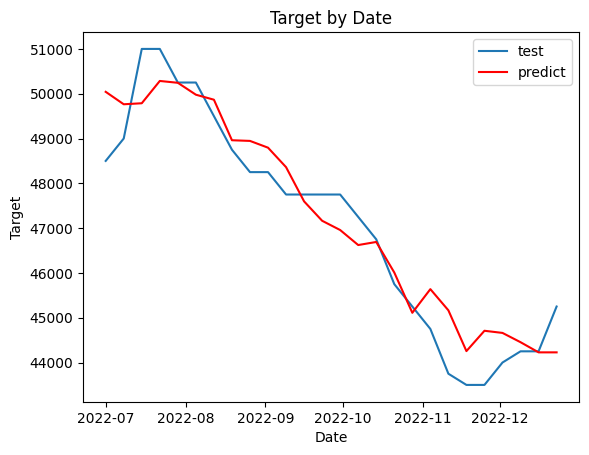

In [11]:
# plt.figure(figsize=(32, 12))
plt.plot(test_df['timestamp'], test_df['target'], label='test' )
plt.plot(forecast_df['timestamp'], forecast_df['target'], color='red', label='predict')

plt.title('Target by Date')
plt.xlabel('Date')
plt.ylabel('Target')

plt.legend()

plt.show() 

In [12]:
test_df

,timestamp,target
0,2022-07-01,48500.0
1,2022-07-08,49000.0
2,2022-07-15,51000.0
3,2022-07-22,51000.0
4,2022-07-29,50250.0
5,2022-08-05,50250.0
6,2022-08-12,49500.0
7,2022-08-19,48750.0
8,2022-08-26,48250.0
9,2022-09-02,48250.0


In [13]:
forecast_df

,timestamp,target
0,2022-07-01,50042.345237
1,2022-07-08,49764.555574
2,2022-07-15,49787.202553
3,2022-07-22,50284.998352
4,2022-07-29,50243.866810
5,2022-08-05,49978.144724
6,2022-08-12,49866.508336
7,2022-08-19,48961.573627
8,2022-08-26,48946.731263
9,2022-09-02,48795.445562


In [14]:
result_df = test_df.copy()
result_df

,timestamp,target
0,2022-07-01,48500.0
1,2022-07-08,49000.0
2,2022-07-15,51000.0
3,2022-07-22,51000.0
4,2022-07-29,50250.0
5,2022-08-05,50250.0
6,2022-08-12,49500.0
7,2022-08-19,48750.0
8,2022-08-26,48250.0
9,2022-09-02,48250.0


In [15]:
result_df = pd.concat([result_df, forecast_df['target']], axis=1)

In [16]:
result_df.columns = ['timestamp', 'target', 'forecast']

In [17]:
def forecast_plot(df, ts, tg, fr, clr_dn, clr_up):
  h = df.shape[0]
  df['label'] = np.NaN

  clr = []
  r_clr = []

  for i in range(0, len(df[tg]) - 1):
    if df[tg][i + 1] - df[tg][i] > 0:
      r_clr.append(clr_up)
    if df[tg][i + 1] - df[tg][i] <= 0:
      r_clr.append(clr_dn)

  for i in range(0, h - 1):
    if df[fr][i + 1] - df[fr][i] > 0:
      df['label'][i] = 1
      clr.append(clr_up)
    if df[fr][i + 1] - df[fr][i] <= 0:
      df['label'][i] = 0
      clr.append(clr_dn)

  plt.figure(figsize=(64, 12), dpi=80)
  r_clr.append("black")
  clr.append("black")
  for i in range(len(df[tg])):
    #plt.scatter(df[ts], df[tg], color=r_clr)
    plt.scatter(df[ts], df[fr], color=clr)
  plt.plot(df[ts], df[tg], label='test')
  plt.plot(df[ts], df[fr], label='predict')
  plt.legend(fontsize=50, handlelength=4)
  

# Выведение итогов

In [18]:
result_df

,timestamp,target,forecast
0,2022-07-01,48500.0,50042.345237
1,2022-07-08,49000.0,49764.555574
2,2022-07-15,51000.0,49787.202553
3,2022-07-22,51000.0,50284.998352
4,2022-07-29,50250.0,50243.866810
5,2022-08-05,50250.0,49978.144724
6,2022-08-12,49500.0,49866.508336
7,2022-08-19,48750.0,48961.573627
8,2022-08-26,48250.0,48946.731263
9,2022-09-02,48250.0,48795.445562


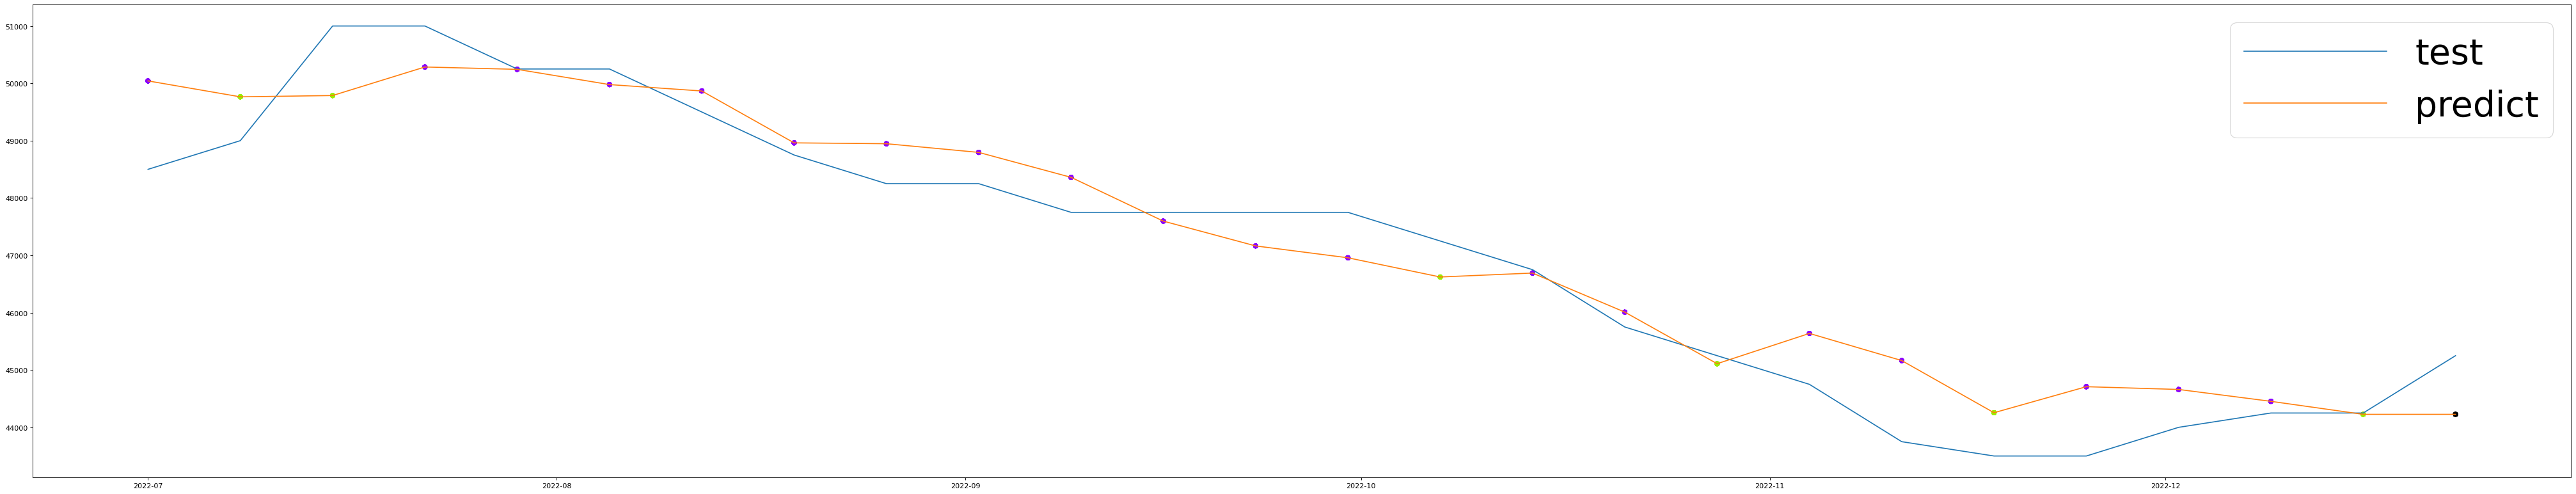

In [19]:
forecast_plot(result_df, 'timestamp', 'target', 'forecast', '#8b00ff', '#9BED00')

In [20]:
def catBoost(ts, date_train_start, date_train_end, date_test_start, date_test_end, HORIZON):
  train_ts, test_ts = ts.train_test_split(
    train_start=date_train_start,
    train_end=date_train_end,
    test_start=date_test_start,
    test_end=date_test_end,
)

  lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
  train_ts.fit_transform([lags])
  model = CatBoostMultiSegmentModel(iterations=1004, depth=6, learning_rate=0.0300007, l2_leaf_reg=2.001, bootstrap_type='MVS')
  model.fit(train_ts)
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  train_ts.inverse_transform()

  # test_df = test_ts.to_pandas(True)[['timestamp','target']]
  forecast_df = forecast_ts.to_pandas(True)[['timestamp','target']]

  result_df = forecast_df.copy()
  # result_df = pd.concat([result_df, test_df['target']], axis=1)

  # result_df.columns = ['timestamp', 'forecast', 'target']
  result_df.columns = ['timestamp', 'forecast']

  return result_df

In [21]:
result = catBoost(ts, "2018-01-05", "2022-06-30", "2022-07-01", "2022-12-23", 23)
result

,timestamp,forecast
0,2022-07-01,50042.345237
1,2022-07-08,49764.555574
2,2022-07-15,49787.202553
3,2022-07-22,50284.998352
4,2022-07-29,50243.866810
5,2022-08-05,49978.144724
6,2022-08-12,49866.508336
7,2022-08-19,48961.573627
8,2022-08-26,48946.731263
9,2022-09-02,48795.445562


In [22]:
def forecasting_plot(df, ts, fr, clr_dn, clr_up):
  h = df.shape[0]
  df['label'] = np.NaN

  clr = []
  r_clr = []

  for i in range(0, h - 1):
    if df[fr][i + 1] - df[fr][i] > 0:
      df['label'][i] = 1
      clr.append(clr_up)
    if df[fr][i + 1] - df[fr][i] <= 0:
      df['label'][i] = 0
      clr.append(clr_dn)

  plt.figure(figsize=(64, 12), dpi=80)
  r_clr.append("black")
  clr.append("black")
  labels = ['неделя {0}'.format(i) for i in range(1, len(df[fr])+1)]
  for i in range(len(df[fr])):
    plt.scatter(df[ts], df[fr], color=clr,)
  for label, x, y in zip(labels, df[ts], df[fr]):
    plt.annotate(
      label,
      xy=(x, y), xytext=(-20, 20),
      textcoords='offset points', ha='right', va='bottom',
      bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
      arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    
  plt.plot(df[ts], df[fr], label='predict')
  plt.legend(fontsize=50, handlelength=4)

In [26]:
def result(n):
    reinforce = catBoost(ts, "2018-01-05", "2022-06-30", "2022-07-01", "2022-12-23", n+10)
    # print(reinforce)
    forecasting_plot(reinforce, 'timestamp', 'forecast', '#8b00ff', '#9BED00')
    rf = reinforce.forecast
    print(rf)
    print(f"Прогноз на 10 недель, начиная с {n} недели.")
    buy=1
    for i in range(9):
        if rf[n-1+i]<=rf[n-1+i+1]:
            buy +=1
        else:
            break
    print("Покупать на ", buy, "недели.")
    # print("Минимальная цена: ", min(rf))
    # print("Покупать на ", rf.loc[reinforce.forecast == (min(rf))].index[0], "неделе.")

# Вывод итогового результата

0     50042.345237
1     49764.555574
2     49787.202553
3     50284.998352
4     50243.866810
5     49978.144724
6     49866.508336
7     48961.573627
8     48946.731263
9     48795.445562
10    48360.755616
11    47596.685939
Name: forecast, dtype: float64
Прогноз на 10 недель, начиная с 2 недели.
Покупать на  3 недели.


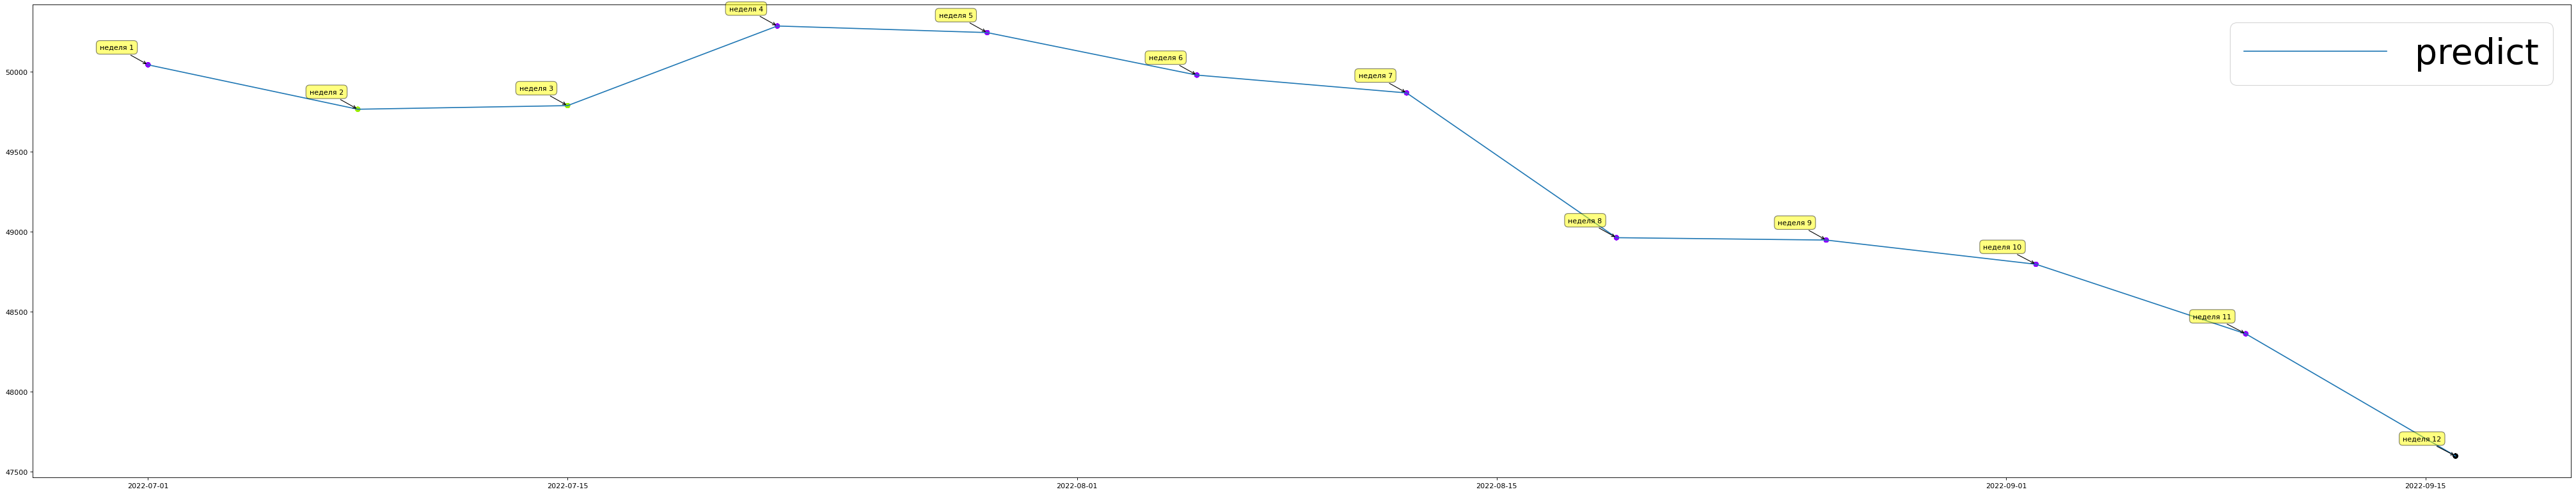

In [28]:
# Здесь указывается число на сколько недель предсказывать
result(2)